In [6]:
def show_grayscale_image(img,title=""):
  """
  Function to show the image as a grayscale image. This function will be used to display results.
  """
  plt.imshow(img,cmap='gray')
  plt.title(title)

In [7]:
import numpy as np

def PSNR(image1, image2, peak=255):
  """ 
 This function calculates the Peak signal-to-noise ratio given image 1 and 2
  param 1: image 1
  param 2: image 2
  param 3: max value of pixel 8-bit image (255)
  rtype: float
  return: PSNR value
  """

  # Calculating the Mean Squared Error
  mse = MSE(image1,image2)

  # Calculating the Peak Signal Noise Ratio
  psnr = 10*np.log10(peak**2/mse)

  return psnr

In [11]:


def MSE(image1,image2):
  """ 
  This function calculates the Mean Squared Error given image 1 and image 2
  param 1: image 1
  param 2: image 2
  rtype: float
  return: MSE value
  """

  # Calculating the Mean Squared Error
  mse = np.mean(np.square(image1.astype(float) - image2.astype(float)))
  
  return mse



In [12]:
from skimage.util import random_noise
import numpy as np

class noisy_system():

  def create_salt_and_pepper_noise(self,img,value=0.05):
    """
    function to add salt and pepper noise to the image
    param 1: image to which noise needs to be added 
    rtype: uint8 (w,h)
    return: image with salt and pepper noise
    
    """

    # Transforming the pixel value from 0-255 to 0-1 float
    img = img/255

   
    h = img.shape[0] # height of the image
    w = img.shape[1] # width of the image

    # ratio of salt and pepper is set to equal
    s = 0.5
    p = 0.5

 
    result = img.copy()

    # Adding salt noise to the image
    salt = np.ceil(value * img.size * s)
    res = []
    for i in img.shape:
      res.append(np.random.randint(0, i-1, int(salt)))
    
    result[res] = 1

    # Adding pepper noise to the image
    pepper = np.ceil(value * img.size * p)
    res = []
    for i in img.shape:
      res.append(np.random.randint(0, i-1, int(salt)))
    
    result[res] = 0

    # Convert the result back to uint8
    result = np.uint8(result*255)

    return result

  def create_gaussian_noise(self,img,mean=0,var=0.01):
    """
    function to add gaussian noise to the image
    param img: input image
    rtype: uint8 (w,h)
    return: image with gaussian noise
    """

    # Transforming the pixel values from 0-255 to 0-1 float
    img = img/255

  
    result = img.copy()

    # Adding gaussian noise to the image
    gauss = np.random.normal(mean, var**0.5, img.shape)
    result = result + gauss
    result = np.clip(result, 0, 1)

    # Converting the result back to uint8
    result = np.uint8(result*255)

    return result

/var/folders/bx/bq7q6hg931j52_lx_hj1hfkh0000gn/T/ipykernel_51681/2925301243.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[res] = 1
/var/folders/bx/bq7q6hg931j52_lx_hj1hfkh0000gn/T/ipykernel_51681/2925301243.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[res] = 0


Total Time taken: 0.01s

Statistics:
SNP -> PSNR: 17.99 | MSE: 1031.80
GSN -> PSNR: 20.47 | MSE: 583.02


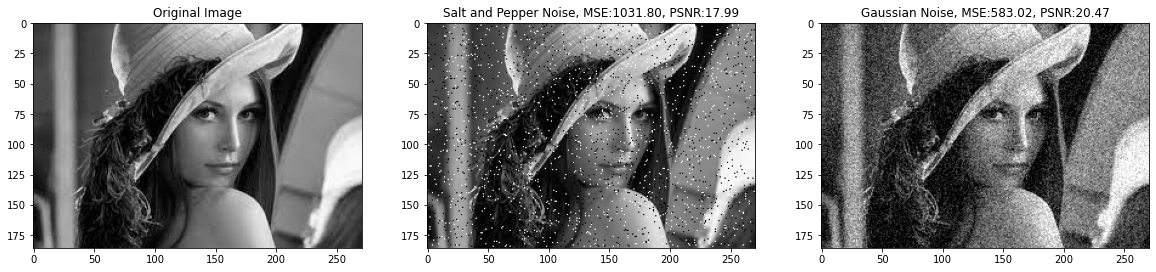

In [16]:
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output



start = time.time()

add_noise = noisy_system()
image = cv2.imread(f"download.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


snp_noisy_image = add_noise.create_salt_and_pepper_noise(image.copy())
gauss_noisy_image = add_noise.create_gaussian_noise(image.copy())

end = time.time()
print(f"Total Time taken: {end-start:.2f}s\n")
print("Statistics:")
print(f"SNP -> PSNR: {PSNR(snp_noisy_image,image):.2f} | MSE: {MSE(snp_noisy_image,image):.2f}")
print(f"GSN -> PSNR: {PSNR(gauss_noisy_image,image):.2f} | MSE: {MSE(gauss_noisy_image,image):.2f}")


plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
show_grayscale_image(image,"Original Image")

plt.subplot(2,3,2)
show_grayscale_image(snp_noisy_image,
          f"Salt and Pepper Noise, MSE:{MSE(image,snp_noisy_image):.2f}, PSNR:{PSNR(image,snp_noisy_image):.2f}")

plt.subplot(2,3,3)
show_grayscale_image(gauss_noisy_image,
          f"Gaussian Noise, MSE:{MSE(image,gauss_noisy_image):.2f}, PSNR:{PSNR(image,gauss_noisy_image):.2f}")
plt.show()

In [18]:
from numba import jit

# Function to analyze the neighbors for each pixel in the window size (small_window x small_window)

def list_neighbours(padded_img,small_window,big_window,h,w):
    # Finding width of the neighbor window and padded image from the center pixel
    s_width = small_window//2
    b_width = big_window//2

    # Initializing the result
    neighbors = np.zeros((padded_img.shape[0],padded_img.shape[1],small_window,small_window))

    # Finding the neighbors of each pixel in the original image using the padded image
    for i in range(b_width,b_width + h):
        for j in range(b_width,b_width + w):   
            neighbors[i,j] = padded_img[(i - s_width):(i + s_width + 1) , (j - s_width):(j + s_width + 1)]
    
    return neighbors

# Function to calculate the weighted average value for each pixel

def weighted_average(pixelWindow, neighborWindow, Nw):
    # Initialize numerator and denominator of Ip (Ip = Ip_Numerator/Z)
    Ip_Numerator,Z = 0,0

    # Calculating Ip for pixel p using neighborood pixels r
    for i in range(neighborWindow.shape[0]):
      for j in range(neighborWindow.shape[1]):
        # (small_window x small_window) array for pixel r
        r_window = neighborWindow[i,j]

        # Coordinates of pixel r
        r_x,r_y = r_window.shape[0]//2,r_window.shape[1]//2

        # Ir value
        Ir = r_window[r_x, r_y]

        # Norm of Ip - Ir
        w = np.exp(-1*((np.sum((pixelWindow - r_window)**2))/Nw))

        # Calculating Ip
        Ip_Numerator = Ip_Numerator + (w*Ir)
        Z = Z + w

    return Ip_Numerator/Z

In [21]:
class NLMeans():

  def NLM_denoise(self,img,h=30,small_window=7,big_window=21):
    """
    function to perform nlmeans filtering.

    param img: noisy image that needs denoising
    param h: sigma h (as stated in the paper)
    param small_window: dimension of small_window
    param big_window: dimension of big window
    rtype: uint8 (w,h)
    return: solved image
    """

    # Padding the original image with reflect mode
    padded_img = np.pad(img,big_window//2,mode='reflect')

    return self.NLM(padded_img,img,h,small_window,big_window)

  @staticmethod

  def NLM(padded_img, img, h, small_window, big_window):
    # initializing small_window neighbourhood
    Nw = (h**2)*(small_window**2)


    h,w = img.shape # storing the height and width of the image

    result = np.zeros(img.shape)

    # Calculating size of the neighbor windows
    b_width = big_window//2
    s_width = small_window//2

    # Listing the neighbors of each pixel
    neighbors = list_neighbours(padded_img, small_window, big_window, h, w) 

    # NL Means algorithm
    for i in range(b_width, b_width + h):
        for j in range(b_width, b_width + w):
    
            pixelWindow = neighbors[i,j]

          
            neighborWindow = neighbors[(i - b_width):(i + b_width + 1) , (j - b_width):(j + b_width + 1)]

 
            Ip = weighted_average(pixelWindow, neighborWindow, Nw)

            # Converting the pixel values so that it stays between 0-255 
            result[i - b_width, j - b_width] = max(min(255, Ip), 0)

    return result

In [ ]:
salt_and_paper_h = 36
gaussian_h = 27


%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
 
 
denoiser = NLMeans()
image = cv2.imread(f"download.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 

start = time.time()
 
salt_and_pepper_denoise  = denoiser.NLM_denoise(snp_noisy_image,h=salt_and_paper_h)
gaussian_denoise = denoiser.NLM_denoise(gauss_noisy_image,h=gaussian_h)
 
end = time.time()
print(f"Time taken: {end-start:.2f}s\n")
 
print("Metrics:")
print(f"salt_and_paper_h: {salt_and_paper_h} , gaussian_h: {gaussian_h}\n")
print(f"SNP -> PSNR: {PSNR(salt_and_pepper_denoise,image):.2f} | MSE: {MSE(salt_and_pepper_denoise,image):.2f}")
print(f"GSN -> PSNR: {PSNR(gaussian_denoise,image):.2f} | MSE: {MSE(gaussian_denoise,image):.2f}\n")
 
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
show_grayscale_image(image,"Original Image")
plt.subplot(3,3,2)
show_grayscale_image(my_salt_and_pepper_denoise,
          f"Salt and Pepper Denoise, MSE:{MSE(image,salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,3)
show_grayscale_image(my_gaussian_denoise,
          f"Gaussian Denoise, MSE:{MSE(image,gaussian_denoise):.2f}, PSNR:{PSNR(image,gaussian_denoise):.2f}")
plt.show()